## Customer churn prediction

#### Dataset description
- This dataset is randomly collected from an Iranian telecom company database over a period of 12 months. 
- A total of 3150 rows of data, each representing a customer, bear information for 13 columns.


#### Columns description
- **Call Failures**: number of call failures
- **Complains**: binary (0: No complaint, 1: complaint)
- **Subscription**: Length: total months of subscription
- **Charge Amount**: Ordinal attribute (0: lowest amount, 9: highest amount)
- **Seconds of Use**: total seconds of calls
- **Frequency of use**: total number of calls
- **Frequency of SMS**: total number of text messages
- **Distinct Called Numbers**: total number of distinct phone calls 
- **Age Group**: ordinal attribute (1: younger age, 5: older age)
- **Tariff Plan**: binary (1: Pay as you go, 2: contractual)
- **Status**: binary (1: active, 2: non-active)
- **Churn**: binary (1: churn, 0: non-churn)
- **Customer Value**: The calculated value of customer

#### Imports

In [220]:
import math
import warnings
import pandas as pd
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

#### Declaring constants / Project config

In [221]:
INPUT_PATH = './input/'
OUTPUT_PATH = './output/'

INPUT_FILENAME = 'raw.csv'

LABELS_DICT = {
    'call_failure': 'Call Failure',
    'complains': 'Complains',
    'subscription_length': 'Subscription Length',
    'charge_amount': 'Charge Amount',
    'seconds_of_use': 'Seconds of Use',
    'frequency_of_use': 'Frequency of Use',
    'frequency_of_sms': 'Frequency of SMS',
    'distinct_called_numbers': 'Distinct Called Numbers',
    'age_group': 'Age Group',
    'tariff_plan': 'Tariff Plan',
    'status': 'Status',
    'age': 'Age',
    'customer_value': 'Customer Value',
    'churn': 'Churn'
}

target_col = 'churn'

px.defaults.template = 'plotly_dark'

# pio.renderers.default = "notebook" 

# za graph preview na Github-u
png_renderer = pio.renderers["png"]
png_renderer.width = 1400
png_renderer.height = 500
pio.renderers.default = "png" 

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

#### Reading input data

In [222]:
df = pd.read_csv(INPUT_PATH + INPUT_FILENAME)

#### Previewing data attributes

In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call  Failure            3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription  Length     3150 non-null   int64  
 3   Charge  Amount           3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int64  
 10  Status                   3150 non-null   int64  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  Churn                    3150 non-null   int64  
dtypes: float64(1), int64(13)

In [224]:
df.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


In [225]:
df.describe()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000
mean,7.627937,0.076508,32.541905,0.942857,4472.459683,69.460635,73.174921,23.509841,2.826032,1.077778,1.248254,30.998413,470.972916,0.157143
std,7.263886,0.265851,8.573482,1.521072,4197.908687,57.413308,112.237560,17.217337,0.892555,0.267864,0.432069,8.831095,517.015433,0.363993
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,15.000000,0.000000,0.000000
25%,1.000000,0.000000,30.000000,0.000000,1391.250000,27.000000,6.000000,10.000000,2.000000,1.000000,1.000000,25.000000,113.801250,0.000000
50%,6.000000,0.000000,35.000000,0.000000,2990.000000,54.000000,21.000000,21.000000,3.000000,1.000000,1.000000,30.000000,228.480000,0.000000
75%,12.000000,0.000000,38.000000,1.000000,6478.250000,95.000000,87.000000,34.000000,3.000000,1.000000,1.000000,30.000000,788.388750,0.000000
max,36.000000,1.000000,47.000000,10.000000,17090.000000,255.000000,522.000000,97.000000,5.000000,2.000000,2.000000,55.000000,2165.280000,1.000000


In [226]:
df.isna().sum()

Call  Failure              0
Complains                  0
Subscription  Length       0
Charge  Amount             0
Seconds of Use             0
Frequency of use           0
Frequency of SMS           0
Distinct Called Numbers    0
Age Group                  0
Tariff Plan                0
Status                     0
Age                        0
Customer Value             0
Churn                      0
dtype: int64

#### Profiling data (ydata_profiler)

In [227]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Profiling Report")

profile.to_file(f'{OUTPUT_PATH}profiling_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### Renaming columns to snake case

In [228]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns = df.columns.str.replace('__', '_')

df.head()

,call_failure,complains,subscription_length,charge_amount,seconds_of_use,frequency_of_use,frequency_of_sms,distinct_called_numbers,age_group,tariff_plan,status,age,customer_value,churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


#### Data visualization and descriptive analysis

In [229]:
def visualize_hist(columns):
    fig = make_subplots(rows=math.ceil(len(columns) / 2), cols=2)

    for i, col in enumerate(columns):
        row = i // 2 + 1  
        col_num = i % 2 + 1 
        fig.add_histogram(x=df[col], row=row, col=col_num, name=col)

        fig.update_xaxes(title_text=LABELS_DICT[col], row=row, col=col_num)
        fig.update_yaxes(title_text='Frequency', row=row, col=col_num)

    fig.update_layout(height=1400, showlegend=False, template='plotly_dark', title_text="Histograms of Columns")
    fig.show(renderer="png", width=1400, height=2000)

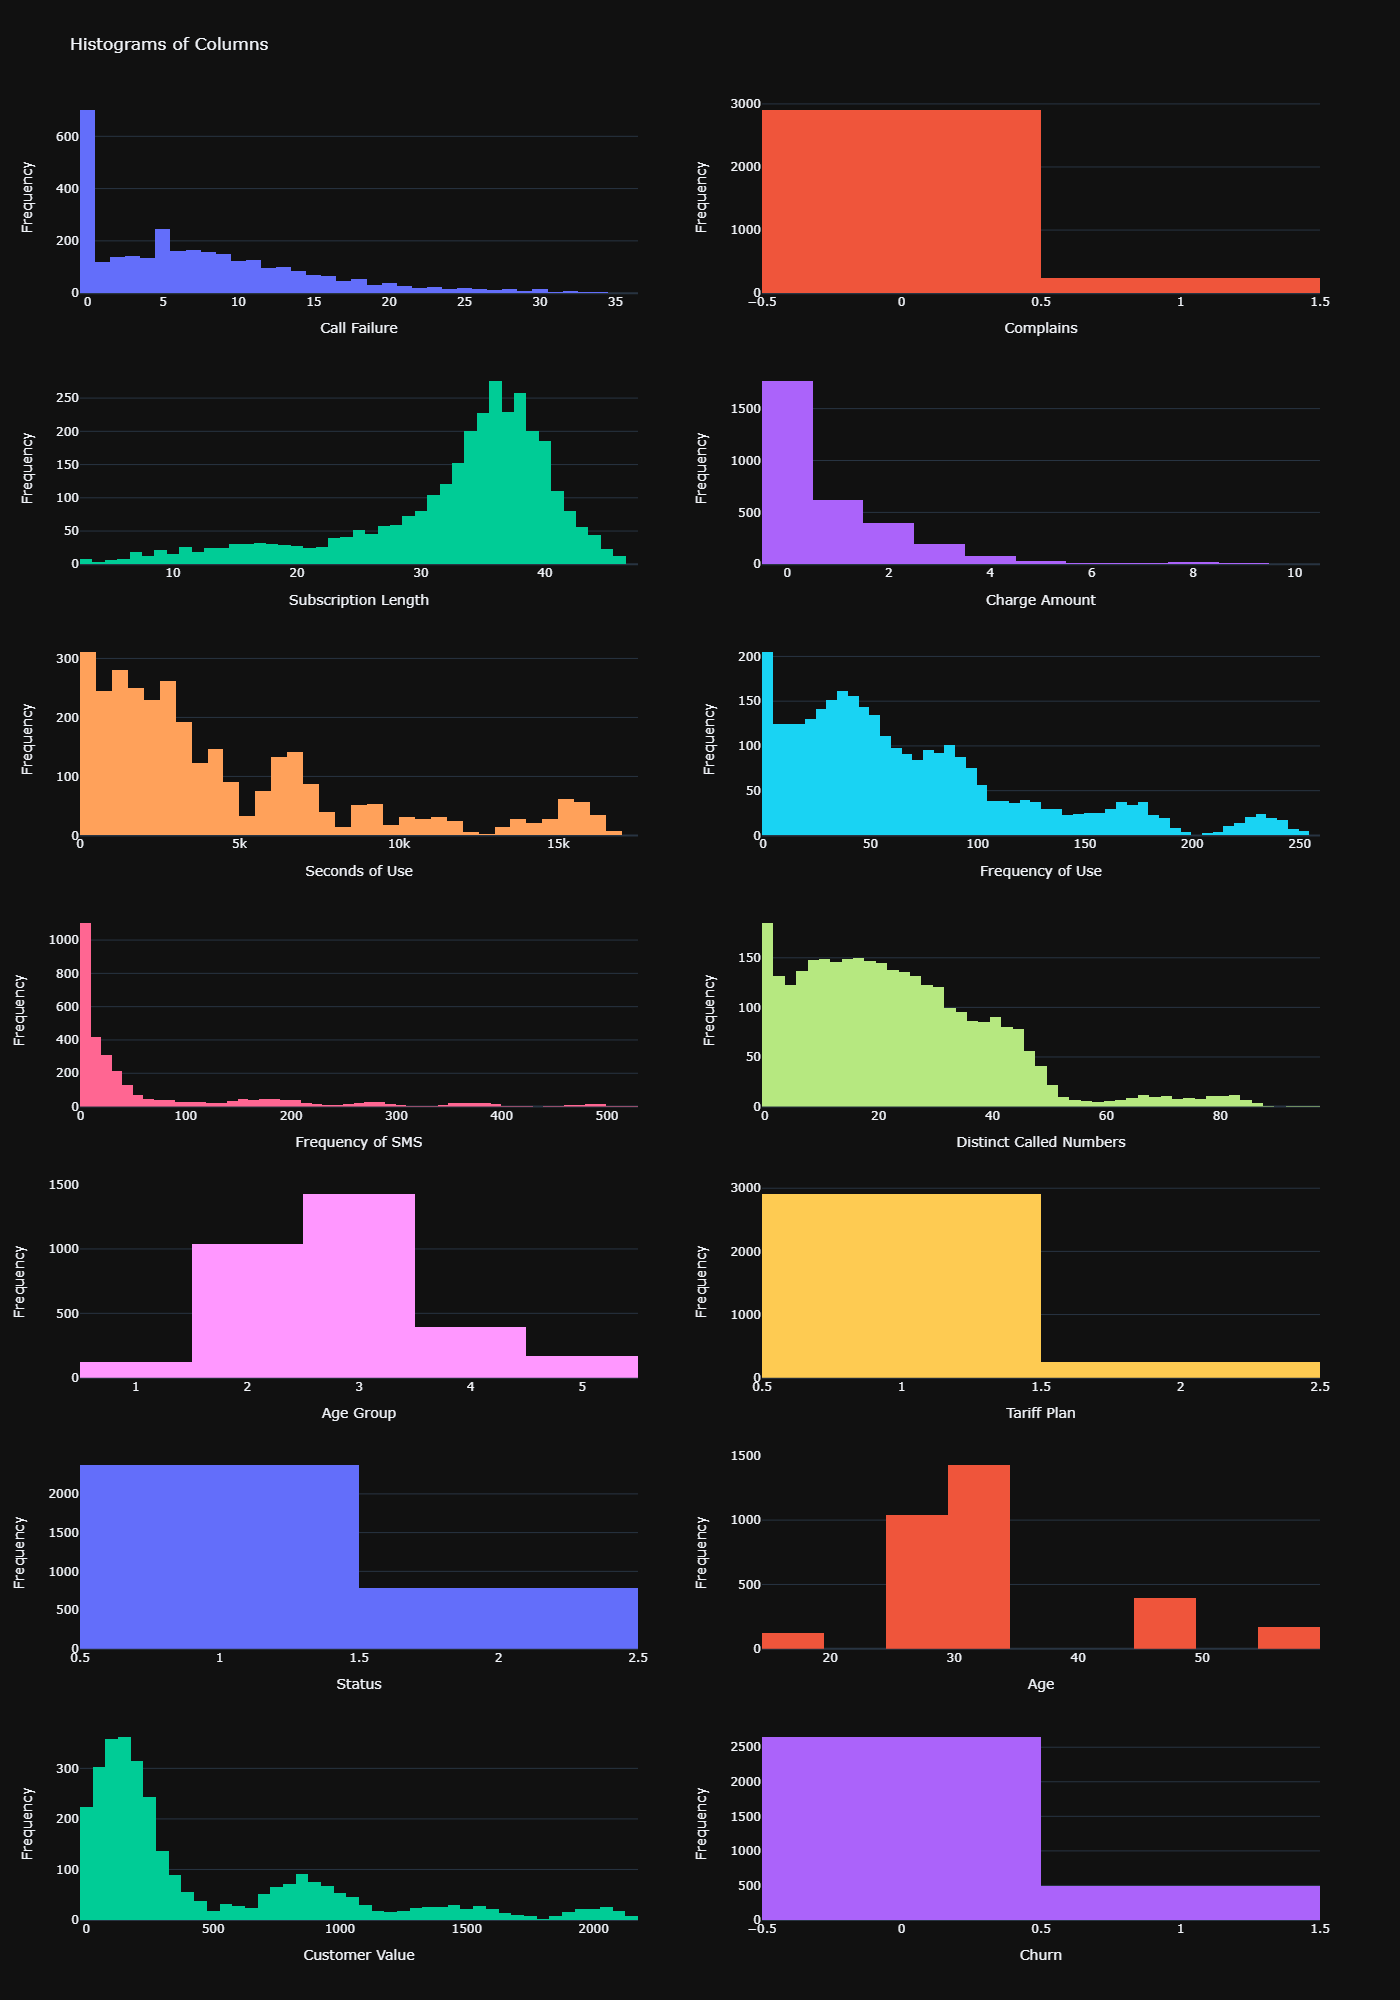

In [230]:

visualize_hist(df.columns.tolist())

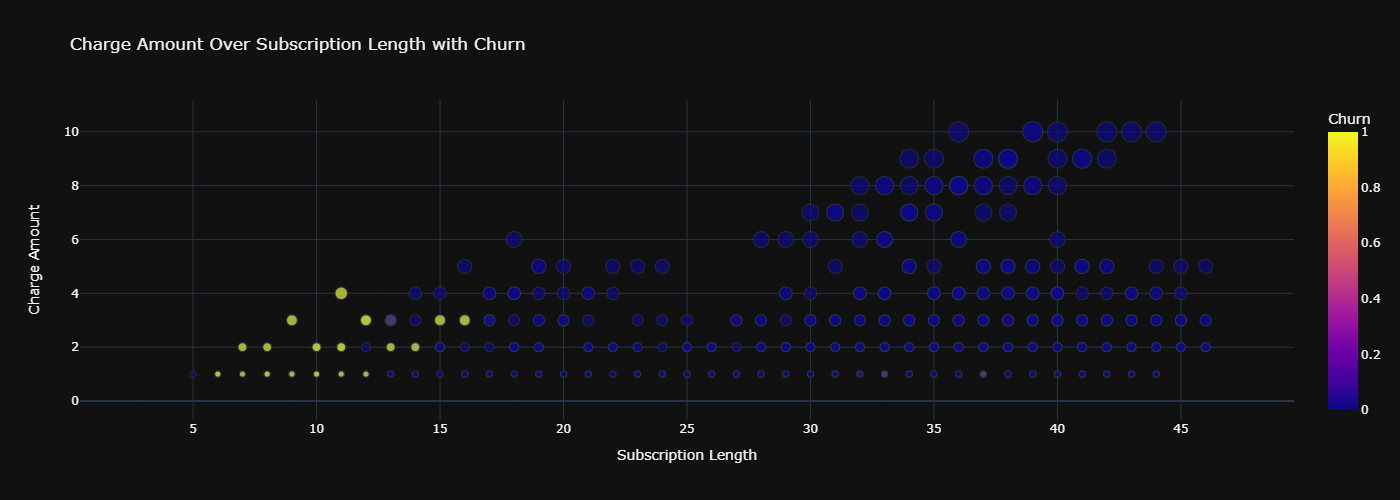

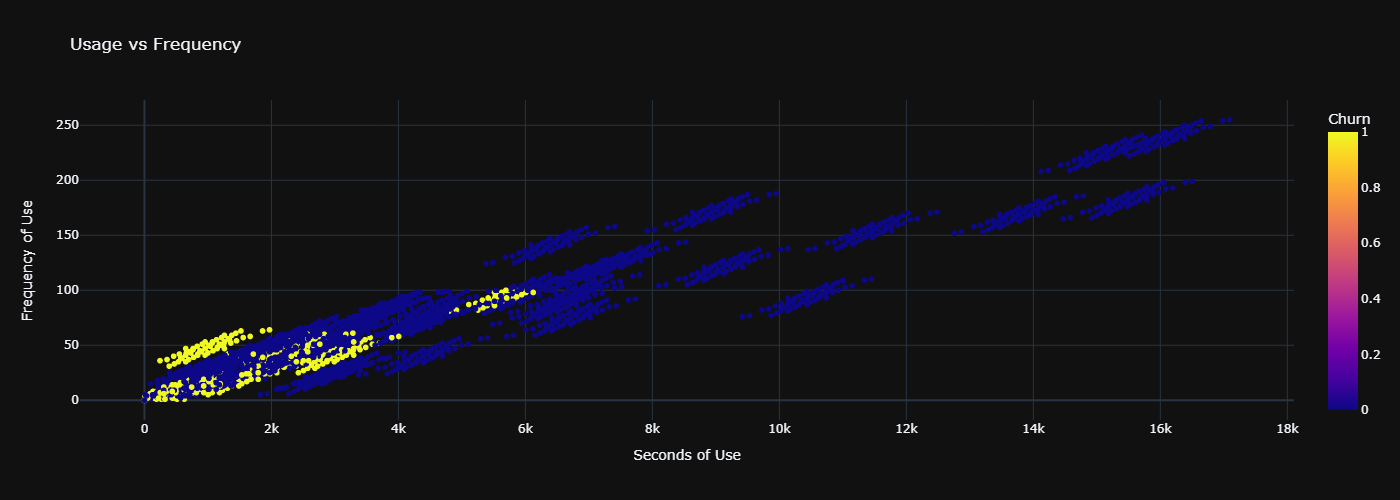

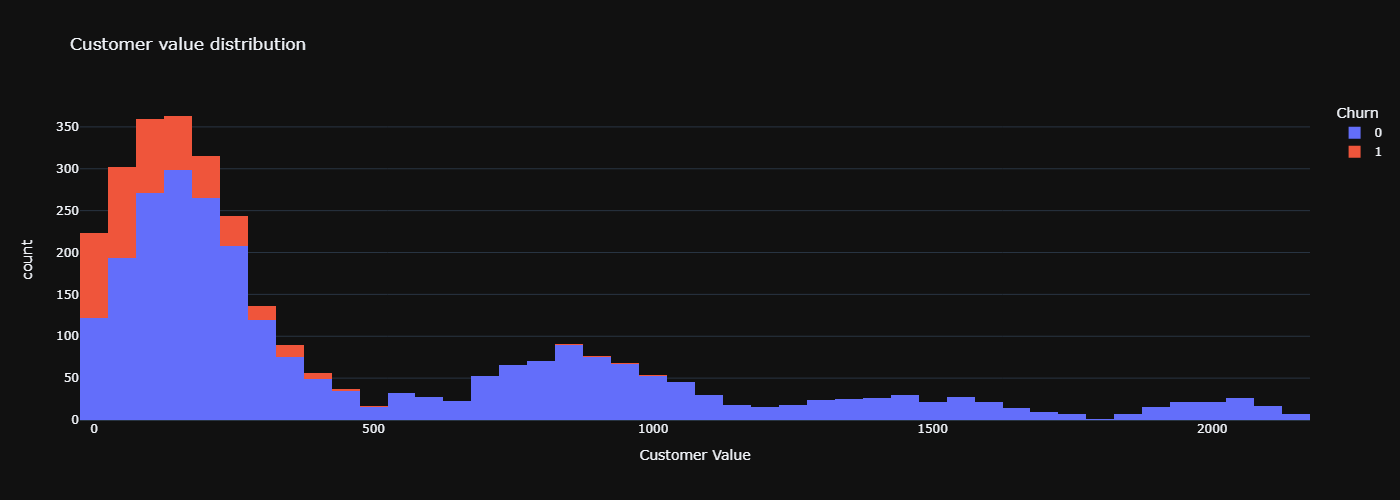

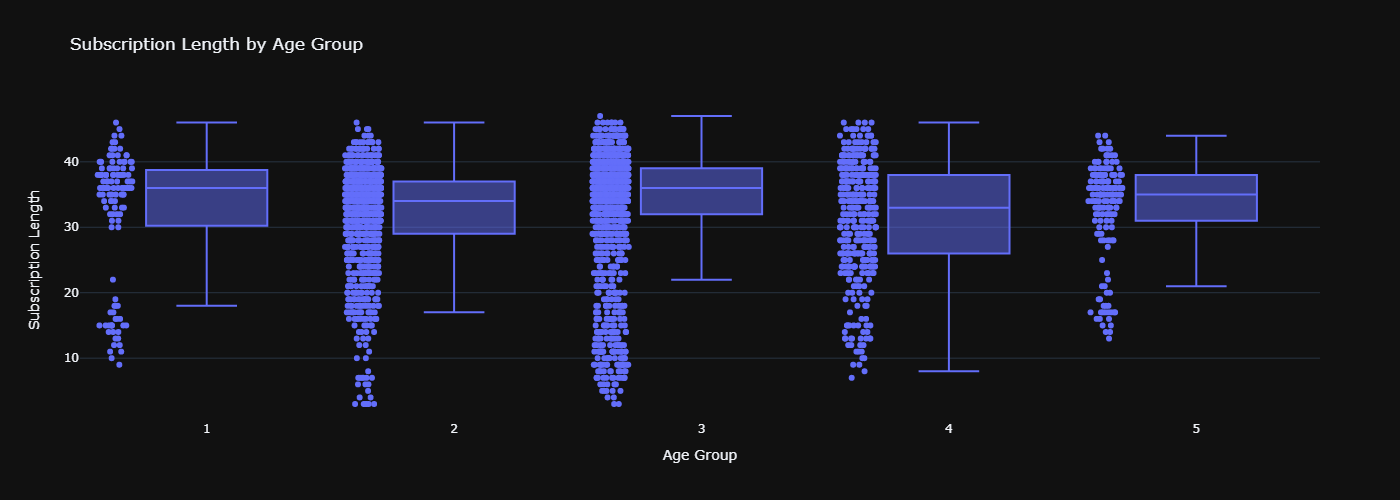

In [231]:

fig = px.scatter(df, 
                 x='subscription_length', 
                 y='charge_amount', 
                 color='churn', 
                 size='charge_amount',
                 hover_data=['subscription_length'],
                 title='Charge Amount Over Subscription Length with Churn',
                 labels=LABELS_DICT)
fig.show()

fig = px.scatter(df,
                x='seconds_of_use',
                y='frequency_of_use',
                color='churn',
                labels=LABELS_DICT,
                title='Usage vs Frequency')
fig.show()

fig = px.histogram(df,
                    x='customer_value',
                    color='churn',
                    labels=LABELS_DICT,
                    title='Customer value distribution')
fig.show()

fig = px.box(df, 
            x='age_group', 
            y='subscription_length', 
            labels=LABELS_DICT,
            points='all', 
            title='Subscription Length by Age Group')
fig.show()


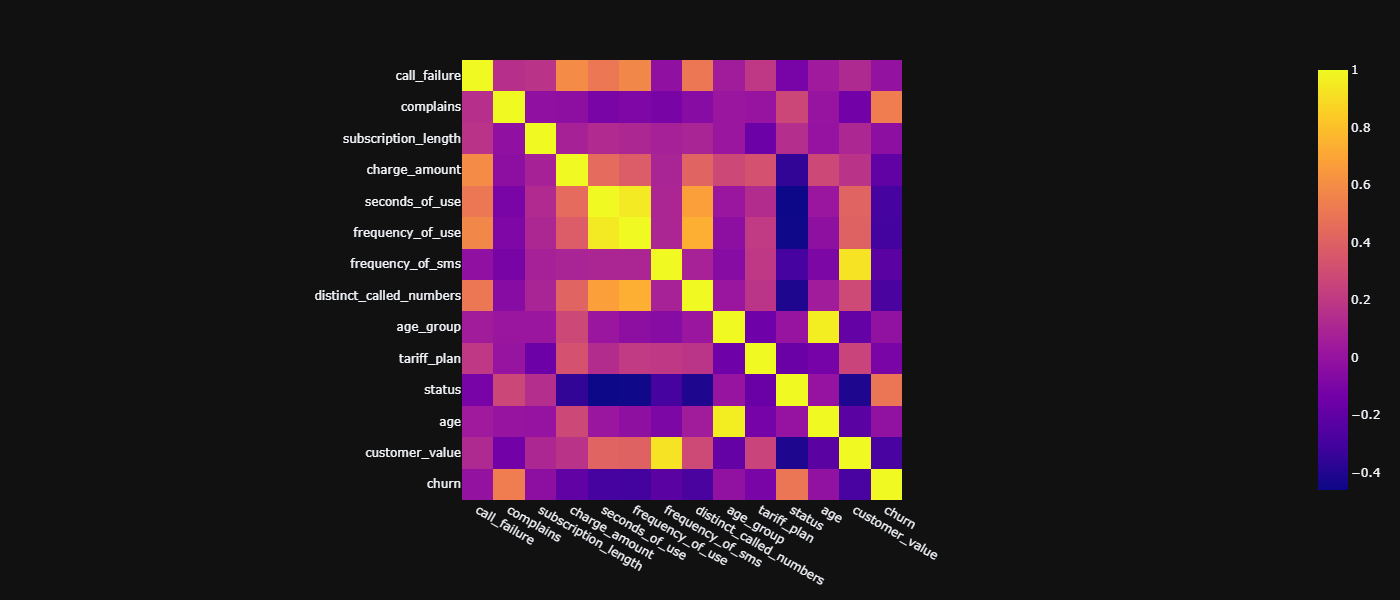

In [232]:
correlation_matrix = df.corr()

fig = px.imshow(correlation_matrix,
                labels=LABELS_DICT,
                x=correlation_matrix.index,
                y=correlation_matrix.columns,
                height=600)

# fig.show()
fig.show(renderer="png", height=600)

### Preprocessing data

In [233]:
cols_to_drop = ['age']
df = df.drop(columns=cols_to_drop, index=1)

#### Dropping duplicates

In [234]:
print(df.duplicated().value_counts())

df.drop_duplicates(inplace=True)

False    2850
True      299
dtype: int64


#### Feature scalling with MinMaxScaler

In [235]:
numerical_cols = ['call_failure', 'subscription_length', 'charge_amount',
                     'seconds_of_use', 'frequency_of_use', 'frequency_of_sms', 'distinct_called_numbers', 'customer_value']

df[numerical_cols] = MinMaxScaler().fit_transform(df[numerical_cols])

##### Categorical encoding (One hot)

In [236]:
categorical_cols = ['complains', 'tariff_plan', 'status']

df = pd.get_dummies(df, columns=categorical_cols)

In [237]:
df.head()
df.shape

(2850, 16)

##### Handling imbalanced classes (SMOTE)

In [238]:
print("\nClass Distribution for 'churn' Column:")
print(df['churn'].value_counts())


pipeline = Pipeline([
    ('over', SMOTE(sampling_strategy=0.5)),
    ('under', RandomUnderSampler(sampling_strategy=1.0))
])

X_resampled, y_resampled = pipeline.fit_resample(df.drop(target_col, axis=1), df[target_col])
df = pd.concat([X_resampled, y_resampled], axis=1)

print("\nClass Distribution for 'churn' column after SMOTE:")
print( df['churn'].value_counts())


Class Distribution for 'churn' Column:
0    2404
1     446
Name: churn, dtype: int64

Class Distribution for 'churn' column after SMOTE:
0    1202
1    1202
Name: churn, dtype: int64


#### Removing outliers (IRQ)

In [239]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    data_no_outliers = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    
    return data_no_outliers

for column in numerical_cols:
    df = remove_outliers_iqr(df, column)

In [240]:
df.shape

(1521, 16)

#### Spliting data

In [241]:
X = df.drop(target_col, axis=1)
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Defining Classifiers

In [242]:
classifiers = [
    {
        'name': 'SVM',
        'classifier': SVC(),
        'param_grid': {
            # 'classifier__C': [0.1, 1, 10], 
            # 'classifier__kernel': ['linear', 'rbf']
        },
    },
    {
        'name': 'RandomForest',
        'classifier': RandomForestClassifier(),
        'param_grid': {
            'classifier__n_estimators': [50, 100, 200], 
            'classifier__max_depth': [None, 10, 20]
        },
    },
    {
        'name': 'LogisticRegression',
        'classifier': LogisticRegression(),
        'param_grid': {
            # 'classifier__C': [0.1, 1, 10],
            # 'classifier__penalty': ['l2'],
            # 'classifier__max_iter': [1000],
        },
    },
    {
        'name': 'GradientBoosting',
        'classifier': GradientBoostingClassifier(),
        'param_grid': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7],
        },
    },
    {
        'name': 'KNeighbors',
        'classifier': KNeighborsClassifier(),
        'param_grid': {
            # 'classifier__n_neighbors': [3, 5, 7],
            # 'classifier__weights': ['uniform', 'distance'],
        },
    },
    {
        'name': 'DecisionTree',
        'classifier': DecisionTreeClassifier(),
        'param_grid': {
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__max_depth': [None, 5, 10],
        },
    },
    {
        'name': 'NaiveBayes',
        'classifier': GaussianNB(),
        'param_grid': {},
    },
    {
        'name': 'AdaBoost',
        'classifier': AdaBoostClassifier(),
        'param_grid': {
            # 'classifier__n_estimators': [50, 100, 200],
            # 'classifier__learning_rate': [0.01, 0.1, 0.2],
        },
    },
        {
        'name': 'ExtraTrees',
        'classifier': ExtraTreesClassifier(),
        'param_grid': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [None, 10, 20],
        },
    },
    {
        'name': 'Bagging',
        'classifier': BaggingClassifier(),
        'param_grid': {
            # 'classifier__n_estimators': [50, 100, 200],
        },
    },
]

#### Model training and evaluation

SVM Test Set Accuracy: 84.92%
RandomForest Test Set Accuracy: 93.77%
LogisticRegression Test Set Accuracy: 82.30%
GradientBoosting Test Set Accuracy: 94.10%
KNeighbors Test Set Accuracy: 92.46%
DecisionTree Test Set Accuracy: 91.15%
NaiveBayes Test Set Accuracy: 82.62%
AdaBoost Test Set Accuracy: 89.84%
ExtraTrees Test Set Accuracy: 95.08%
Bagging Test Set Accuracy: 93.44%

Overall best model:
Model: ExtraTrees
Test Set Accuracy: 95.08%


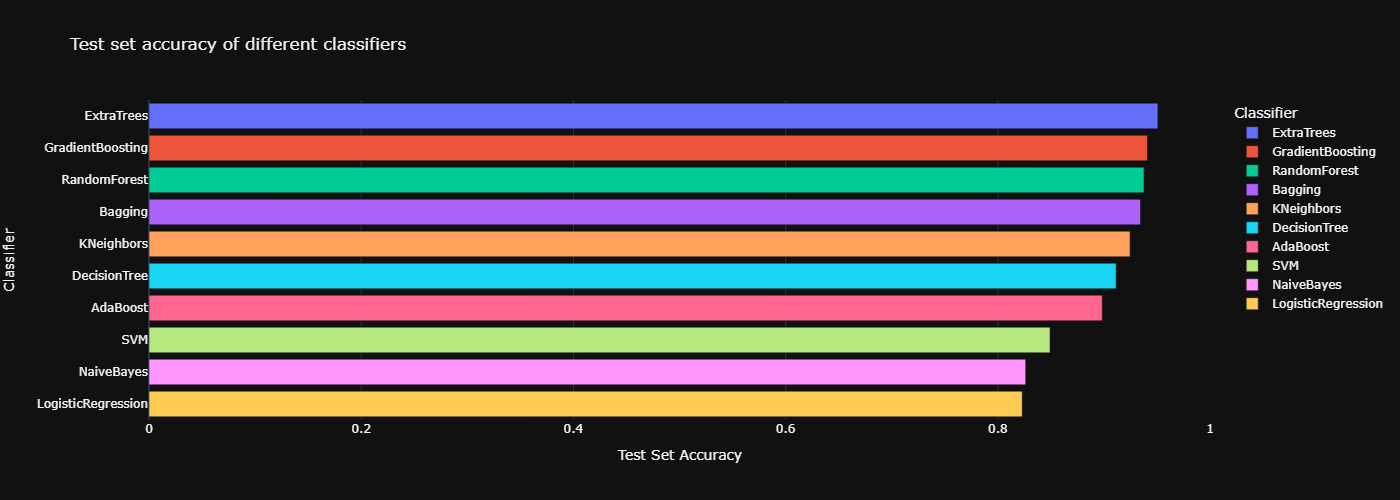

In [243]:
def train_evaluate_model(classifier, X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ('pca', PCA(n_components=10)), 
        ('classifier', classifier['classifier']),
    ])

    grid_search = GridSearchCV(pipeline, classifier['param_grid'], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"{classifier['name']} Test Set Accuracy: {test_accuracy*100:.2f}%")

    result = {
        'name': classifier['name'],
        'test_accuracy': test_accuracy,
        'best_params': best_params,
        'conf_matrix': confusion_matrix(y_test, y_pred),
        'class_report': classification_report(y_test, y_pred),
    }

    return result


def plot_results(results):
    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values(by='test_accuracy', ascending=False)

    fig = px.bar(
        df_results, 
        x='test_accuracy', 
        y='name', 
        orientation='h', 
        title='Test set accuracy of different classifiers',
        color='name',
        labels={'name': 'Classifier'}
    )

    fig.update_layout(xaxis_title='Test Set Accuracy', yaxis_title='Classifier')
    fig.show()

best_overall_model_name = None
best_overall_accuracy = 0.0
results = []

with open(f'{OUTPUT_PATH}model_eval_results.txt', 'w') as file:
    for classifier in classifiers:
        file.write(f"Training and evaluating {classifier['name']}...\n")
        result = train_evaluate_model(classifier, X_train, X_test, y_train, y_test)
        results.append(result)

        if result['test_accuracy'] > best_overall_accuracy:
            best_overall_model_name = classifier['name']
            best_overall_accuracy = result['test_accuracy']

        file.write(f"{classifier['name']} Confusion Matrix:\n{result['conf_matrix']}\n")
        file.write(f"{classifier['name']} Classification Report:\n{result['class_report']}\n")
        file.write(f"Best hyperparameters: {result['best_params']}\n")
        file.write("\n" + "="*50 + "\n")

best_model_result = next(item for item in results if item["name"] == best_overall_model_name)

print("\nOverall best model:")
print(f"Model: {best_overall_model_name}")
print(f"Test Set Accuracy: {best_overall_accuracy*100:.2f}%")

plot_results(results)

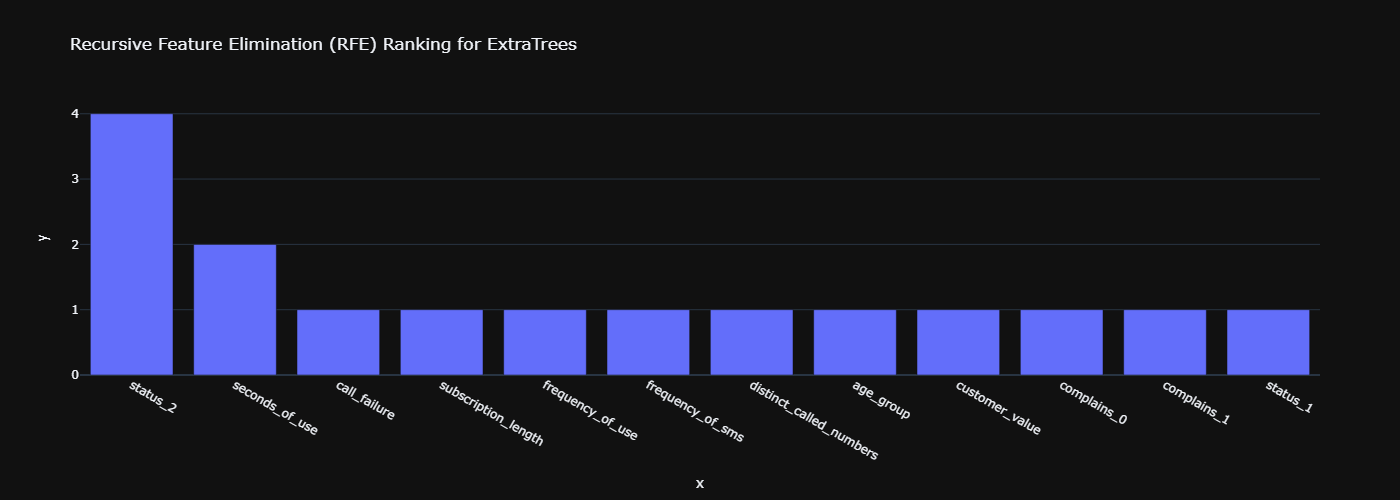

In [244]:
best_model_results = [result for result in results if result['name'] == best_overall_model_name][0]
best_model_params = best_model_results['best_params']
best_classifier = next((classifier for classifier in classifiers if classifier['name'] == best_overall_model_name), None)

if not best_classifier:
    print(f"No information found for the best overall model: {best_overall_model_name}")
    exit()

classifier_params = {key.replace('classifier__', ''): value for key, value in best_model_params.items() if key.startswith('classifier__')}

best_model = best_classifier['classifier'].__class__(**classifier_params)
best_model.fit(X_train, y_train)

nr_features_to_select = 12

selector = RFE(best_model, n_features_to_select=nr_features_to_select, step=1)
selector = selector.fit(X_train, y_train)

selected_features_mask = selector.support_
selected_features = X_train.columns[selected_features_mask]

k = nr_features_to_select 

top_features = selected_features[:k]
top_rankings = selector.ranking_[:k]

sorted_indices = sorted(range(len(top_rankings)), key=lambda k: top_rankings[k], reverse=True)
top_features = [top_features[i] for i in sorted_indices]
top_rankings = [top_rankings[i] for i in sorted_indices]

fig_rfe = px.bar(
    x=top_features,
    y=top_rankings,
    title=f'Recursive Feature Elimination (RFE) Ranking for {best_overall_model_name}',
)

fig_rfe.show()

In [275]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

best_model.fit(X_train_selected, y_train)

y_pred = best_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Performance for {best_overall_model_name} with selected features:")
print(f"Accuracy: {accuracy*100:.2f}%")
print("Classification Report:\n", class_report)

Performance for ExtraTrees with selected features:
Accuracy: 95.08%
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       107
           1       0.96      0.96      0.96       198

    accuracy                           0.95       305
   macro avg       0.95      0.94      0.95       305
weighted avg       0.95      0.95      0.95       305

